In [28]:
# Cargar liberías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch

In [29]:
df = pd.read_csv('../drinking_water_potability.csv')
df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.080795,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,333.775777,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,333.775777,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681736,47580.99160,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.80216,8.061362,333.775777,392.449580,19.903225,66.396293,2.798243,1
3273,9.419510,175.762646,33155.57822,7.350233,333.775777,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.86938,6.303357,333.775777,402.883113,11.168946,77.488213,4.708658,1


In [30]:
features = df.columns[:-1]
labels = df.columns[-1]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[labels], test_size=0.2, random_state=42)

In [34]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

c:\Users\nesto\anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [36]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int('units_0',
                                        min_value=32,
                                        max_value=512,
                                        step=32),
                           input_shape=(X_train.shape[1],),
                           activation='relu'))
    for i in range(1, hp.Int('num_layers', 2, 25)):
        model.add(layers.Dense(units=hp.Int(f'units_{i}',
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation=hp.Choice(f'activation_{i}',
                                                   values=['relu', 'tanh', 'sigmoid'])))
        if hp.Choice('bath_norm', [True, False]):
            model.add(layers.BatchNormalization())
        if hp.Choice('dropout', [True, False]):
            model.add(layers.Dropout(rate=hp.Float(f'dropout_{i}',
                                                   min_value=0.0,
                                                   max_value=0.5,
                                                   default=0.25,
                                                   step=0.05)))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
    return model

In [37]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=5,
    directory='my_dir2',
    project_name='test1_water_potability')

In [38]:
tuner.search_space_summary

<bound method BaseTuner.search_space_summary of <keras_tuner.src.tuners.randomsearch.RandomSearch object at 0x000001D7A76B45B0>>

In [39]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [40]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping])

Trial 10 Complete [00h 00m 49s]
val_accuracy: 0.6511450290679932

Best val_accuracy So Far: 0.6748091697692871
Total elapsed time: 00h 11m 21s


In [41]:
tuner.results_summary()

Results summary
Results in my_dir2\test1_water_potability
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
units_0: 416
num_layers: 4
units_1: 96
activation_1: relu
bath_norm: 1
dropout: 0
dropout_1: 0.45
learning_rate: 0.01
units_2: 32
activation_2: relu
units_3: 32
activation_3: relu
Score: 0.6748091697692871

Trial 02 summary
Hyperparameters:
units_0: 128
num_layers: 7
units_1: 320
activation_1: relu
bath_norm: 1
dropout: 1
dropout_1: 0.15000000000000002
learning_rate: 0.001
units_2: 320
activation_2: sigmoid
units_3: 224
activation_3: tanh
units_4: 160
activation_4: sigmoid
units_5: 160
activation_5: sigmoid
units_6: 352
activation_6: relu
units_7: 192
activation_7: tanh
units_8: 352
activation_8: tanh
units_9: 96
activation_9: relu
units_10: 352
activation_10: sigmoid
units_11: 512
activation_11: tanh
units_12: 512
activation_12: relu
units_13: 192
activation_13: sigmoid
units_14: 384
activation_14: sigmoid
units_15: 512
act

In [42]:
models = tuner.get_best_models(num_models=len(tuner.oracle.trials))
model_scores = [model.evaluate(X_test, y_test) for model in models]

21/21 [==============================] - 1s 3ms/step - loss: 0.6637 - accuracy: 0.6280


In [43]:
results = pd.DataFrame(model_scores, columns=['loss', 'accuracy'])

In [44]:
results.sort_values('accuracy', ascending=False)

,loss,accuracy
5,0.667477,0.628049
7,0.678515,0.628049
8,0.665360,0.628049
9,0.663657,0.628049
0,4264.686035,0.626524
6,0.697923,0.484756
2,0.728867,0.378049
1,0.805629,0.373476
3,1.064322,0.371951
4,0.934603,0.371951


In [45]:
results.reset_index(drop=True, inplace=True)

In [46]:
print(results)

          loss  accuracy
0  4264.686035  0.626524
1     0.805629  0.373476
2     0.728867  0.378049
3     1.064322  0.371951
4     0.934603  0.371951
5     0.667477  0.628049
6     0.697923  0.484756
7     0.678515  0.628049
8     0.665360  0.628049
9     0.663657  0.628049


In [47]:
best_model = models[results.index[0]]

In [48]:
# Entrenar el mejor modelo con todos los datos y guardar la historia
history = best_model.fit(np.concatenate([X_train, X_train]),
                         np.concatenate([y_train, y_train]),
                         epochs=100,
                         callbacks=[early_stopping])

Epoch 1/100
164/164 [==============================] - 3s 3ms/step - loss: 0.6145 - accuracy: 0.6733
Epoch 2/100
164/164 [==============================] - 1s 3ms/step - loss: 0.5988 - accuracy: 0.6880
Epoch 3/100
164/164 [==============================] - 0s 3ms/step - loss: 0.5967 - accuracy: 0.6786
Epoch 4/100
164/164 [==============================] - 1s 3ms/step - loss: 0.5808 - accuracy: 0.6931
Epoch 5/100
164/164 [==============================] - 0s 3ms/step - loss: 0.5758 - accuracy: 0.6958
Epoch 6/100
164/164 [==============================] - 1s 3ms/step - loss: 0.5628 - accuracy: 0.7132
Epoch 7/100
164/164 [==============================] - 0s 3ms/step - loss: 0.5590 - accuracy: 0.7065
Epoch 8/100
164/164 [==============================] - 1s 4ms/step - loss: 0.5613 - accuracy: 0.7132
Epoch 9/100
164/164 [==============================] - 1s 3ms/step - loss: 0.5515 - accuracy: 0.7177
Epoch 10/100
164/164 [==============================] - 0s 3ms/step - loss: 0.5310 - accura

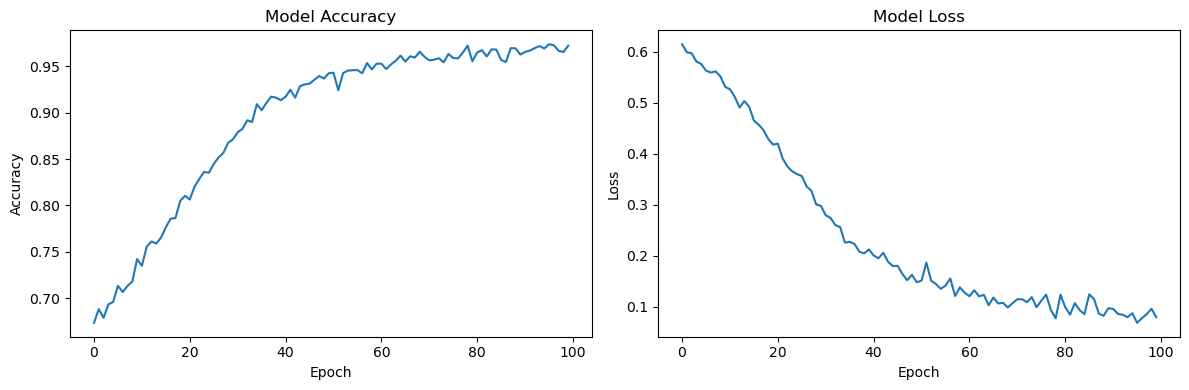

In [49]:
# Graficar la exactitud del entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# Graficar la pérdida del entrenamiento
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()
